In [34]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 10
voxelr = 0.005  
L = 350*voxelr
print 'L',L
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration = -math.log(1e-10)/N/kon
dt=tm*10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr



L 1.75
Vr 5.48379976429
1.25663706144 0.125663706144 0.114239732858
phi 0.103155740411 phir 0.103155740411


In [37]:
Pacc = ka / (6 * math.sqrt(2) * D * voxelr)
r0=0.256318
#k0=3*2**0.5*Pacc*D*2*voxelr
k0=36*2**0.5*D*2*voxelr*Pacc/(Pacc+12)
preb=Pacc/(Pacc-1+1./r0)
kefftheory = k0*(1-preb)
print kon,kefftheory
print (kon-kefftheory)*100/kon

0.114239732858 0.0323255915414
71.703722748


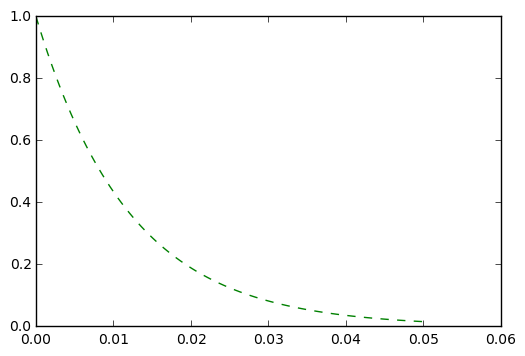

In [2]:
with reaction_rules():#for ODE
    A +B > B | kon

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]
plt.plot(to,nao/N,'g--')

In [3]:
with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr)}
    B |  {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B > B | ka

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())

def rungfrd(i):
    dtfactor = 1e6
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    mat = Integer3(1,1,1)*int(L/2/voxelr)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = egfrd.EGFRDWorld(Real3(L,L,L),matrix_sizes=mat,rng=rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = egfrd.EGFRDSimulator(w)
    #sim.set_dt(tm*dtfactor)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())

In [4]:
def rung(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = gfrd(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n

def rungtest(run):   
    spa = rungfrd(1)
    return spa[:,0]  ,spa[:,1]

def runspa(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = singlerun(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n


In [5]:
run = 10000
#te,nae = rungtest(run)
#print len(te)
ts,nas = runspa(run)


KeyboardInterrupt: 

In [ ]:
mean = np.mean(nas,axis=0)
std = np.std(nas,axis=0)

In [ ]:
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.plot(to,nao,'r--')
print mean[-10:]

In [2]:
l=2
print 'dt',ts[l]-ts[0],tm
ks = -Vr *(mean[l:]-mean[:-l])/mean[:-l]/(ts[l]-ts[0])/N
plt.plot(ts[int(l*0.5):-int(l*0.5)],ks,'.')
Pacc = ka / (6 * math.sqrt(2) * D * voxelr)
print Pacc
r0=0.256318
kefftheory = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)*Pacc/(Pacc+1/r0 -1)
plt.plot(ts,[kon]*len(ts),label='keff')
plt.plot(ts,[kefftheory]*len(ts),label='keff_theory')
plt.legend()
print ka,kon,kefftheory
km = np.mean(ks[-50:])
print km

dt

NameError: name 'ts' is not defined

In [ ]:
#C =1.02085
#r0=0.256318
#voxelr = 0.005/C
#kd = 4*np.pi*4*D*voxelr
#kaa = k_factor*4.0*math.pi*D*4*0.005
#ka = kaa*kd/(3*2**0.5 *D*4*0.005*(1/r0 -1))
#kon = (ka*kd)/(ka+kd)

#import scipy.integrate as integrate
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

tau = ((ka*2*voxelr/(ka+kd))**2)/(D)
#tt= np.linspace(0,0.5,1e3)
#def kt(t):
#    x=ka*((t/tau)**(0.5))/kd
#    return kon*(1+(ka*phi(x)/kd))
#intkt = [integrate.quad(lambda t: kt(t),0,T)[0] for T in tt] 

tt=ts
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tt]

st = [math.exp(-ik*N/Vr) for ik in intkt]
#plt.errorbar(ts,mean/N,std/N,fmt=' ',marker='.')
plt.plot(ts,mean/N,'k')
plt.plot(tt,st,'c-')
plt.plot(to,nao/N,'r--')
#plt.ylim(0.4,1)

In [ ]:
diff = (st-mean/N)*100/(st)
plt.plot(ts,diff,'.')
print np.mean(diff)